In [1]:
from my_functions import*

In [2]:
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

In [3]:
#Prepare the data for the plots

#Choose the range of events to plot
nmin=0
nmax=100

#Select quality 0 Z->mumu
Zmumu_pt=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin:nmax]
Zmumu_eta=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin:nmax]
Zmumu_phi=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin:nmax]

#And select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi = get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)


#Select the ZeroBias data with energy cut
ZeroBias_eta=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())[nmin:nmax]
ZeroBias_phi=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())[nmin:nmax]
ZeroBias_pt=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())[nmin:nmax]

quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected


100%|██████████| 100/100 [00:00<00:00, 1707.98it/s]

energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut


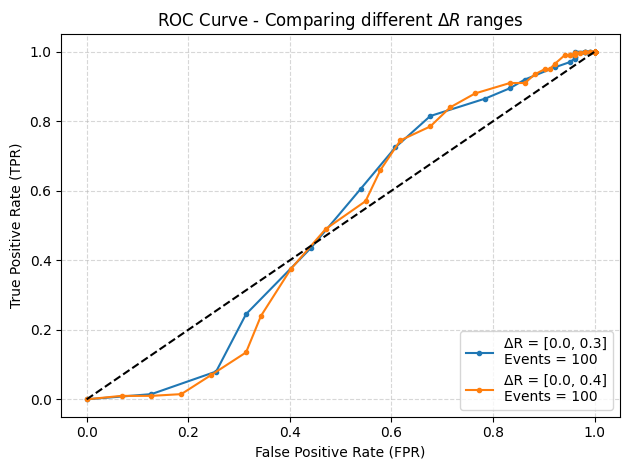

In [4]:
#Now let's do the ROC curve
#Number of bins is proportional to the square root of the number of events for scale 
bins=np.linspace(0,1,5*int(np.sqrt(nmax-nmin)))
dr_min=[0.0,0.0]
dr_max=[0.3,0.4]

#Prepare the data for the plots
ROC_curve=plot_ROC_curve(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                ZeroBias_phi, [nmin,nmax],[nmin,nmax],bins,dr_min,dr_max)

In [9]:
def ROC_curve_optimiser(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                ZeroBias_phi, Zmumu_range, ZeroBias_range, bins, iterations=3, guess=[0.0,1.0]):
    
    current_mean=np.inf
    bins=np.linspace(0,1,5000)
    for i in tqdm(range(iterations), desc="ROC_curve_optimiser: iterating", leave=False):
        new_mean, new_guess, _, _ = ROC_curve_comparer(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                ZeroBias_phi, Zmumu_range, ZeroBias_range, bins, guess)
        if new_mean < current_mean:
            current_mean=new_mean
            current_guess=new_guess
            new_guess=current_guess+np.random.uniform(-0.05,0.05,2)
            if new_guess[0] < 0.0:
                new_guess[0]=0.0
            if new_guess[1] < 0.3:
                new_guess[1]=0.3
        else:
            new_guess=current_guess+np.random.uniform(-0.05,0.05,2)
            if new_guess[0] < 0.0:
                new_guess[0]=0.0
            if new_guess[1] < 0.3:
                new_guess[1]=0.3
        guess=new_guess

    return(current_mean, current_guess)

ROC_curve_optimiser: iterating:   0%|          | 0/3 [00:00<?, ?it/s]





ROC_curve_optimiser: iterating:  33%|███▎      | 1/3 [00:02<00:04,  2.11s/it]





ROC_curve_optimiser: iterating:  67%|██████▋   | 2/3 [00:04<00:02,  2.11s/it]





ROC_curve_optimiser: iterating:   0%|          | 0/3 [00:00<?, ?it/s]        





ROC_curve_optimiser: iterating:  33%|███▎      | 1/3 [00:02<00:04,  2.15s/it]





ROC_curve_optimiser: iterating:  67%|██████▋   | 2/3 [00:04<00:02,  2.11s/it]







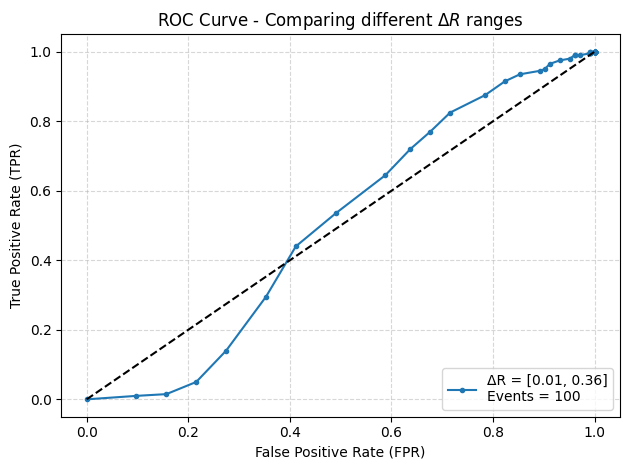

ROC_curve_optimiser: iterating:   0%|          | 0/3 [00:00<?, ?it/s]





ROC_curve_optimiser: iterating:  33%|███▎      | 1/3 [00:02<00:04,  2.10s/it]





ROC_curve_optimiser: iterating:  67%|██████▋   | 2/3 [00:04<00:02,  2.10s/it]







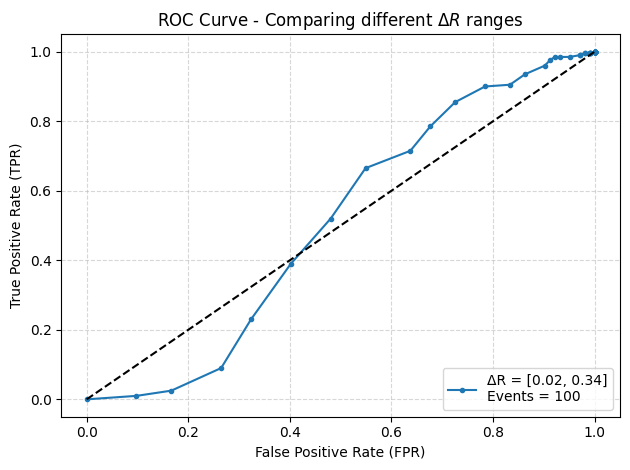

ROC_curve_optimiser: iterating:   0%|          | 0/3 [00:00<?, ?it/s]





ROC_curve_optimiser: iterating:  33%|███▎      | 1/3 [00:02<00:04,  2.12s/it]





ROC_curve_optimiser: iterating:  67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]







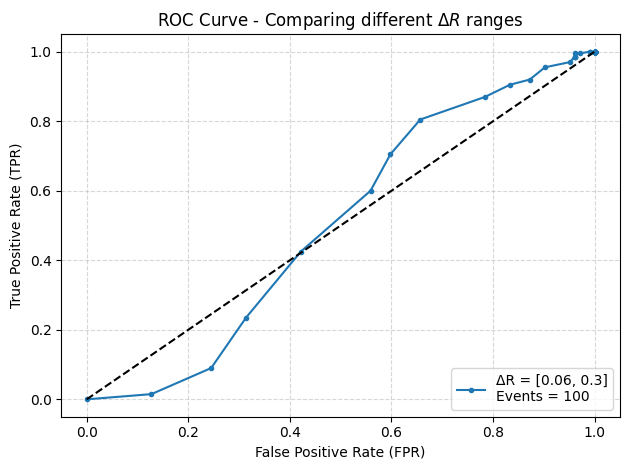

ROC_curve_optimiser: iterating:   0%|          | 0/3 [00:00<?, ?it/s]





ROC_curve_optimiser: iterating:  33%|███▎      | 1/3 [00:02<00:04,  2.10s/it]





ROC_curve_optimiser: iterating:  67%|██████▋   | 2/3 [00:04<00:02,  2.14s/it]







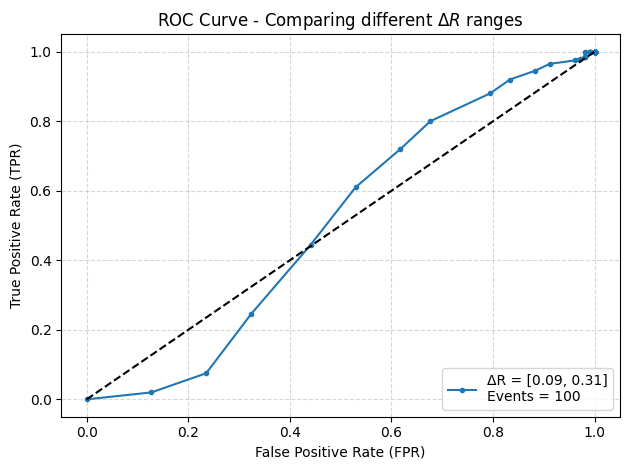

ROC_curve_optimiser: iterating:   0%|          | 0/3 [00:00<?, ?it/s]





ROC_curve_optimiser: iterating:  33%|███▎      | 1/3 [00:02<00:04,  2.20s/it]





ROC_curve_optimiser: iterating:  67%|██████▋   | 2/3 [00:04<00:02,  2.21s/it]







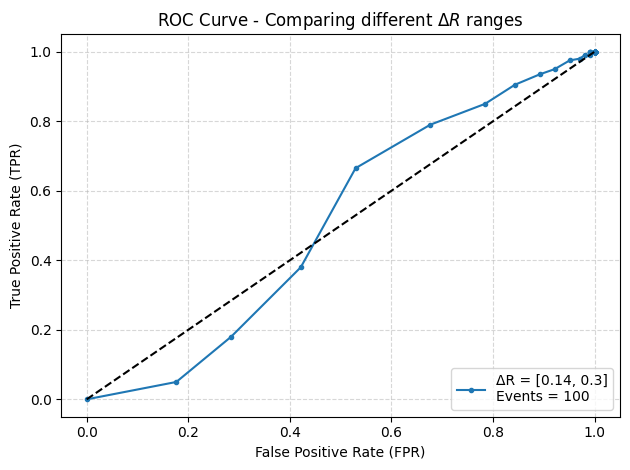

ROC_curve_optimiser: iterating:   0%|          | 0/3 [00:00<?, ?it/s]





ROC_curve_optimiser: iterating:  33%|███▎      | 1/3 [00:02<00:04,  2.18s/it]





ROC_curve_optimiser: iterating:  67%|██████▋   | 2/3 [00:04<00:02,  2.12s/it]







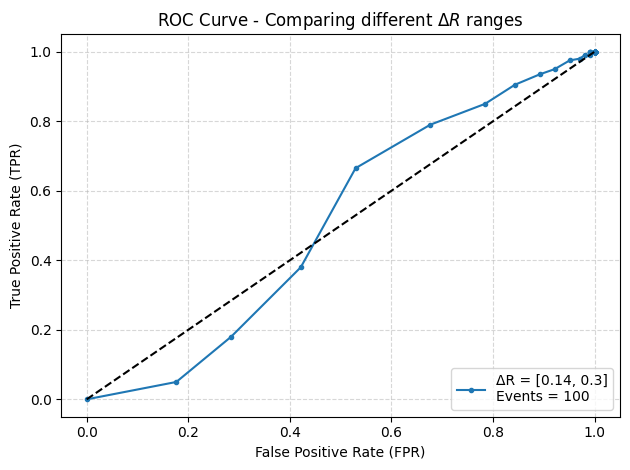

ROC_curve_optimiser: iterating:   0%|          | 0/3 [00:00<?, ?it/s]





ROC_curve_optimiser: iterating:  33%|███▎      | 1/3 [00:02<00:04,  2.17s/it]





ROC_curve_optimiser: iterating:  67%|██████▋   | 2/3 [00:04<00:02,  2.19s/it]







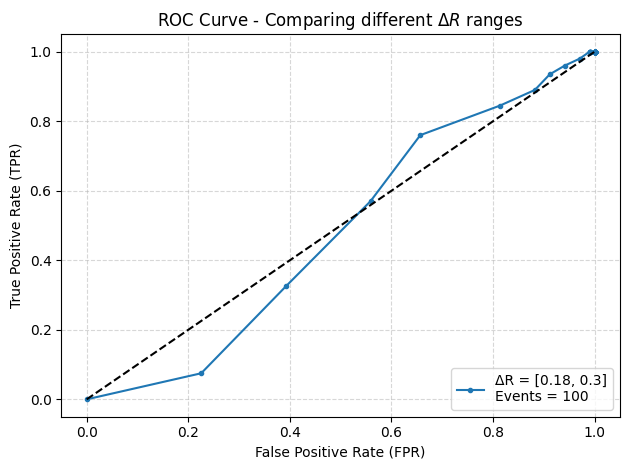

ROC_curve_optimiser: iterating:   0%|          | 0/3 [00:00<?, ?it/s]





ROC_curve_optimiser: iterating:  33%|███▎      | 1/3 [00:02<00:04,  2.21s/it]





ROC_curve_optimiser: iterating:  67%|██████▋   | 2/3 [00:04<00:02,  2.20s/it]







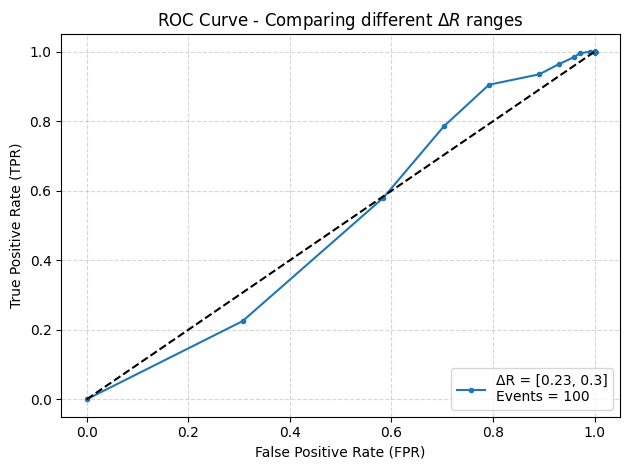

ROC_curve_optimiser: iterating:   0%|          | 0/3 [00:00<?, ?it/s]





ROC_curve_optimiser: iterating:  33%|███▎      | 1/3 [00:02<00:04,  2.18s/it]





ROC_curve_optimiser: iterating:  67%|██████▋   | 2/3 [00:04<00:02,  2.16s/it]







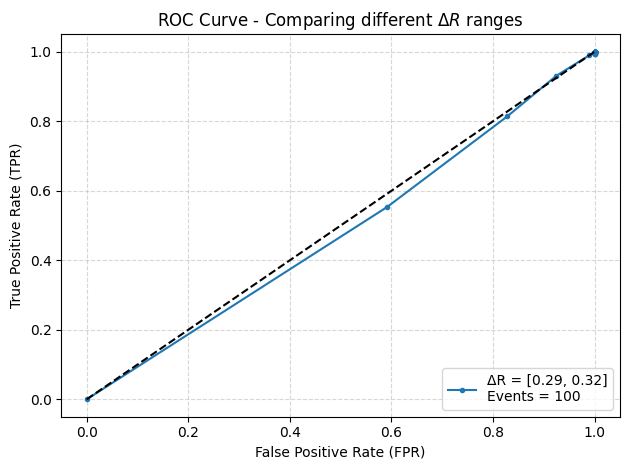

ROC_curve_optimiser: iterating:   0%|          | 0/3 [00:00<?, ?it/s]





ROC_curve_optimiser: iterating:  33%|███▎      | 1/3 [00:02<00:04,  2.26s/it]





ROC_curve_optimiser: iterating:  67%|██████▋   | 2/3 [00:04<00:02,  2.19s/it]





/home/ruben/anaconda3/envs/thesis/lib/python3.13/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


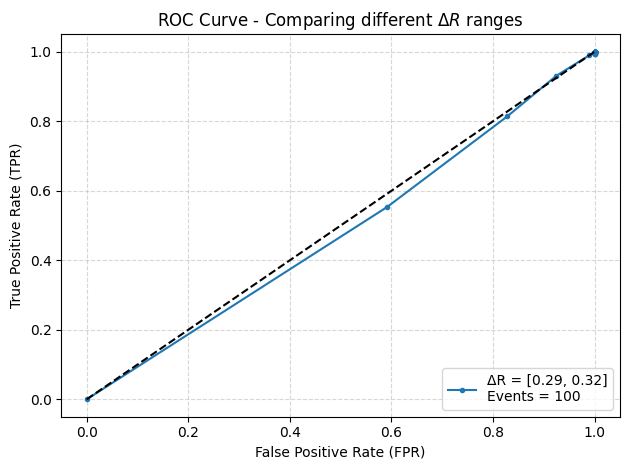

In [10]:
res=ROC_curve_optimiser(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                ZeroBias_phi, [nmin,nmax],[nmin,nmax],bins, guess=[0.0,0.4])
for i in range(10):
    res=ROC_curve_optimiser(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                ZeroBias_phi, [nmin,nmax],[nmin,nmax],bins, guess=res[1])
    
    plot_ROC_curve(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                ZeroBias_phi, [nmin,nmax],[nmin,nmax],bins, [res[1][0]], [res[1][1]])